# Problem 1: Convolutional PDEs

The convolution PDE code from the compphys repository was tested on the NVIDIA Jetson.  Multiple computational methods for convolution were tested and compared for performance.  Each method was tested using 50 iterations for a matrix size of 51x51.  Additionally, each method was timed 10 times and the average runtime was used for comparison.

In [3]:
%pylab inline

import time
import scipy.signal
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Non-Vectorized Laplacian

In this section, we run the most simple, loop-based convolution code given in the CompPhys repository.   

In [4]:
N = 51

u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# initial condition
u_init[N//2,N//2] = 10


In [5]:
LaPlace = np.array([[0., 1., 0.],[1., -4., 1.],[0., 1., 0.]])

In [6]:
for t in range(1,2):
    U_ = u_init
    Ut_= ut_init
    lU_= np.zeros_like(ut_init)
    loop_times = []
    start_time_loop = time.time()
    for k in range(0,50):
        for i in range(1,u_init.shape[0]-2):
            for j in range(1,u_init.shape[1]-2):
                lU_[i+1,j+1] = np.sum(LaPlace*U_[i:i+3,j:j+3])/8.
        U_  = U_+ Ut_
        Ut_ = Ut_ + (1./4.*lU_)
    loop_times.append(time.time() - start_time_loop)
print("Loop Convolution (avg): "+str(sum(loop_times)/len(loop_times)*1000)+" [ms]")

Loop Convolution (avg): 4642.749547958374 [ms]


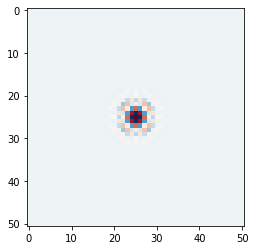

In [7]:
plt.imshow(U_,cmap='RdBu')

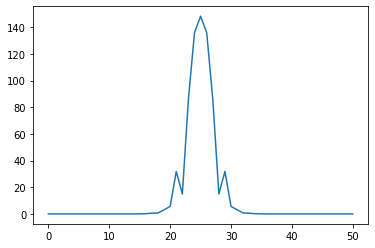

In [8]:
plt.plot(np.abs(U_[:,N//2]))

## Vectorized Laplacian

A vectorized form of the discrete Laplacian is now tested and compared to the loop-based code above.

In [9]:
zero_row = np.zeros(N-2)
zero_col = np.zeros((N,1))
for t in range(1,10):
    U_ = u_init
    Ut_= ut_init
    lU_= np.zeros_like(ut_init)
    vector_times = []
    start_time_loop = time.time()
    for k in range(0,50):
        lU_ = -4*U_[1:-1,1:-1] + U_[2:,1:-1] + U_[:-2,1:-1] + U_[1:-1,2:] + U_[1:-1,:-2]
        
        lU_ = np.vstack([zero_row,lU_,zero_row])
        lU_ = np.hstack((zero_col,lU_,zero_col))
        
        U_  = U_+ Ut_
        Ut_ = Ut_ + (1./4.*lU_)
    vector_times.append(time.time() - start_time_loop)
print("Vectorized (avg): "+str(sum(vector_times)/len(vector_times)*1000)+" [ms]")

Vectorized (avg): 11.033773422241211 [ms]


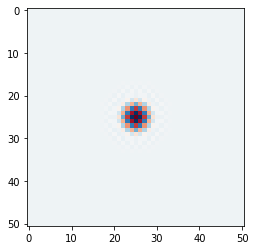

In [10]:
plt.imshow(U_,cmap='RdBu')

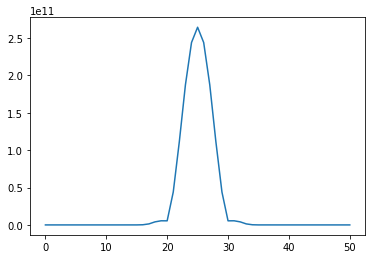

In [11]:
plt.plot(np.abs(U_[:,N//2]))

## Strong Scaling Plot

In [12]:
N_data = np.array([21,51,101,151,201])
loop_time_data = np.array([630.4843425750732 , 4446.524381637573, 18528.327703475952, 42553.7531375885, 75990.71741104126])
vector_time_data = np.array([10.460376739501953, 13.392448425292969, 24.58786964416504, 42.882680892944336, 89.49494361877441])
Sp_data = loop_time_data/vector_time_data

print(Sp_data)

[ 60.27357888 332.01728619 753.55563421 992.32958974 849.1062661 ]


## Comments

A common performance figure used in tests like this is speedup, given by,

$$
S_p = \frac{T_1}{T_p},
$$

where $T_1$ is the runtime on a single core and $T_p$ is the parallel runtime on $p$ cores.  To measure performance in this assignment, we can use a altered form of "speedup" given by the equation,

$$
S_p^N = \frac{T_{loop}^N}{T_{vectorized}^N}.
$$

Simply put, the "speedup" for a problem of size $N$ is defined as the ratio of the runtime of the loop-based method to the runtime of the vectorized method at that specific problem size.  With N=51, the speedup between the loop method and the scipy concolve method is $S_p = 332$, meaning the vectorized code is roughly 300 times faster than the loop-based code.  The speedup was plotted against the problem size (N).  Based on the plot, the vectorized function demonstrates very good scaling up to $N=100$.  At $100<N<100$, the speedup begins to become less linear but is still very good, however, at $N>150$ the speedup decreases.  Therefore, after $N=150$ the vectorized method scales very poorly.   

Text(0.5, 1.0, 'Scaling Plot')

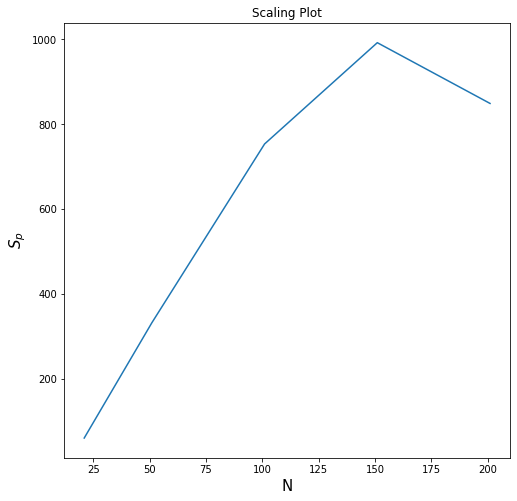

In [13]:
plt.figure(figsize(8,8))
plt.plot(N_data,Sp_data)
plt.xlabel("N",fontsize=15)
plt.ylabel("$S_p$",fontsize=15)
plt.title("Scaling Plot")